In [62]:
# importing many functions to use
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error
# from google.colab import drive
import os
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import v2
import torch.nn.functional as F
import torchvision

import matplotlib
matplotlib.rcParams['text.usetex'] = True

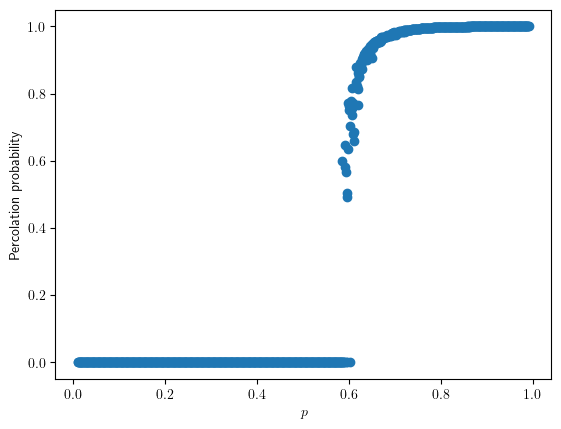

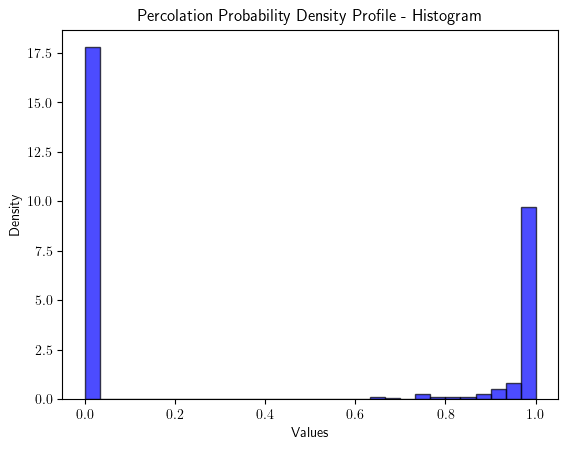

In [3]:
# analyzing the percolation probability data

# reading percolation probability data and collecting the p and percolation probability from the file names
path = r'C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\data\perco_prob'
files = os.listdir(path)
p_list = []
N_list = []
for file in files:
    p, N = file.split("_")
    p = float(p)
    N = float(N[:-4])
    p_list.append(p)
    N_list.append(N)
    
N_array = np.array(N_list)
zero_len = len(N_array[N_array <= 0])
# print(N_list)

# percolation probability plot. It corresponds to a phase transition
plt.scatter(p_list,N_list)
plt.xlabel("$p$")
plt.ylabel("Percolation probability")
plt.show()


# histogram of percolation probability values.
plt.hist(N_list, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Percolation Probability Density Profile - Histogram')
# Show the plot
plt.show()

Text(0.5, 0, 'Value')

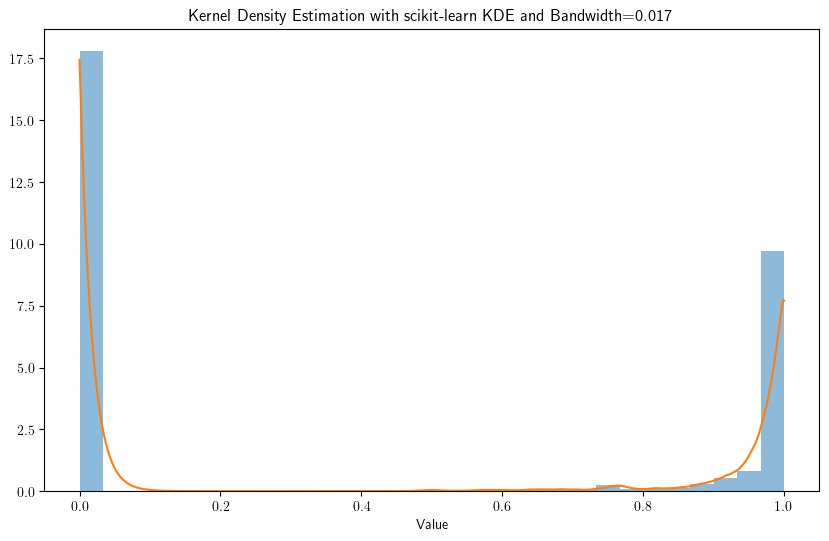

In [4]:
# using KDE to interpolate between percolation probability values
from sklearn.neighbors import KernelDensity
bandwidth = 0.017
kernel = 'exponential'
kde = KernelDensity(bandwidth=bandwidth,kernel=kernel)
kde.fit(N_array.reshape(-1,1))
x_values = np.linspace(min(N_array), max(N_array), 1039).reshape(-1, 1)

# Compute the log-densities for the given values
log_densities = kde.score_samples(x_values)

# Convert log-densities to densities
densities = np.exp(log_densities)

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(N_array, bins=30, density=True, alpha=0.5, label='Histogram')
plt.plot(x_values, densities, label='Kernel Density Estimation (sklearn)')
plt.title(f'Kernel Density Estimation with scikit-learn KDE and Bandwidth={bandwidth}')
plt.xlabel('Value')

In [117]:

device = torch.device('cuda')

class DenseWeightFunction(nn.Module):
    """Module to compute weights given the frequency of each percolation probability value
    """
    def __init__(self, epsilon, alpha):
        super(DenseWeightFunction, self).__init__()
        
        # initialize tuning parameters
        self.epsilon = epsilon
        self.alpha = alpha

    def forward(self, data):
        # use method presented in (Steininger et al, 2021)
        log_densities = torch.tensor(kde.score_samples(data.detach().cpu().numpy()), device=device)
        densities = torch.exp(log_densities)
        densities = torch.clamp(densities, 0,1)
        f_pw = 1 - self.alpha*densities
        f_ppw = torch.where(f_pw > self.epsilon, f_pw, self.epsilon)
        f_w = data.shape[-1]*f_ppw/torch.sum(f_ppw, dim=-1)
        return f_w


class DenseLossFunction(nn.Module):
    def __init__(self, alpha, epsilon):
        super(DenseLossFunction, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        self.dense_weight_function = DenseWeightFunction(epsilon, alpha)

    def forward(self, input_val, target_val):
        # compute weighted loss function
        weights = self.dense_weight_function(target_val)
        loss = ((input_val-target_val)**2 * weights).mean()
        return loss

class LambdaLayer(nn.Module):
    """Layer for testing
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
    
def create_cnn(input_size, kernel_size=None,channel_count=None, padding=0, pooling=2, classification=False):
    """Creates a cnn with an arbitrary architecture

    Args:
        input_size (int): Size of image to input (channel_count[0], input_size, input_size)
        kernel_size (int, optional): Number of kernels in each convolutional layer. Defaults to [5,5,4].
        channel_count (int, optional): Number of channels in each layer, length is one larger than kernel_size. Defaults to [1,8,16,32].
        padding (int or str, optional): Amount of padding in cnn layer (could be "same"). Defaults to 0.
        pooling (int, optional): Kernel and stride for pooling. Disables if falsey. Defaults to 2.
        classification (bool, optional): Whether to make cnn a classification model. Defaults to False.

    Returns:
        nn.Module: the CNN
    """
    # default kernel and channel count
    if kernel_size is None:
        kernel_size = [5,5,4]
    if channel_count is None:
        channel_count = [1,8,16,32]
        
    # customizing layers
    layers = []
    size = input_size
    for i in range(len(kernel_size)):
        layers.append(nn.Conv2d(channel_count[i], channel_count[i+1], kernel_size[i],padding=padding))
        layers.append(nn.ReLU())
        # layers.append(LambdaLayer(lambda x: print(x.shape) or x))
        if padding != 'same':
            size -= kernel_size[i] - 1

        if pooling:
            layers.append(nn.MaxPool2d(pooling))
            size = int((size - (pooling - 1) - 1)/pooling + 1)
            
    # returning model if classification or regression
    if classification:
        return nn.Sequential(*layers, 
                    nn.Flatten(), 
                    nn.Linear(size**2*channel_count[-1], 60),
                    nn.ReLU(),
                    nn.Linear(60,2),
                    nn.LogSoftmax(dim=-1)).to(device)
        
    return nn.Sequential(*layers, 
                        nn.Flatten(), 
                        nn.Linear(size**2*channel_count[-1], 60),
                        nn.ReLU(),
                        nn.Linear(60,1)).to(device)
    

            

class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, output='p', classification_threshold=None):
        """Initializes image dataset

        Args:
            img_dir (str): Path of images
            transform (transform, optional): Transform to apply on data. Defaults to None.
            target_transform (transform, optional): transform to apply on label. Defaults to None.
            output (str, optional): Whether to give the p value 'p' or the second value 'N'. Defaults to 'p'.
            classification_threshold (float, optional): If using classification, can input a threshold. Defaults to None.
        """
        self.image_list = os.listdir(img_dir)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.output = output
        self.classification = classification_threshold

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_list[idx])
        image = read_image(img_path)
        
        # parse two values from file name p_N.png
        p, N = self.image_list[idx].split("_")
        p = np.float32(p)
        N = np.float32(N[:-4])
        
        # apply transform on data
        if self.transform:
            image = self.transform(image)
            
        if self.output == 'p':
            val = p
        else:
            val = N
            
        # apply transform on label
        if self.target_transform:
            val = self.target_transform(val)

        # convert label to classification or regression
        if self.classification:
            return image, (torch.tensor(val)>self.classification).long()
        
        return image, torch.tensor([val])


def rescale_N(N):
    # rescale cluster size to a reasonable scale
    return np.float32(np.log(N)/11)

def undo_rescale_N(N):
    # undo rescale
    return np.float32(np.exp(N*11))


In [103]:
epochs = 50
sizes = [20,25,30,35,40,45,50,55,60,70,80,90,100,110,120,130]
# logging all losses
train_loss = np.zeros((len(sizes), epochs))
test_loss = np.zeros((len(sizes), epochs))

loss_function = torch.nn.MSELoss()

# iterate over all different crop sizes
for k, crop_size in enumerate(sizes):
    # modifying the CNN based on the image size. Without padding, the CNN will reduce the image to 0x0
    if k < 5:
        cnn = create_cnn(crop_size, kernel_size=[4,4,3],channel_count=[1,8,16,32], pooling=False)
    else:
        cnn = create_cnn(crop_size, kernel_size=[6,4,3],channel_count=[1,8,16,32])
        
    # setting optimizer and transform. Set the random crop to the specified crop size
    optimizer = torch.optim.Adam(cnn.parameters(), lr=2e-4)
    transforms = v2.Compose([
        v2.RandomCrop(crop_size),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
    ])
    # load dataset with the transform
    dataset = ImageDataset(r"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\data\perco_image", 
                        transform=transforms, output='N', target_transform=rescale_N)

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    
    # train on multiple epochs
    for epoch in range(epochs): 
        cnn.train()
        epoch_loss = 0
        for i, data in enumerate(train_dataloader):
            imgs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = cnn(imgs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # log loss
        train_loss[k, epoch] = epoch_loss/len(train_dataloader)
        
        # evaluate after each epoch
        cnn.eval()
        epoch_loss = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                imgs, labels = data[0].to(device), data[1].to(device)
                outputs = cnn(imgs)
                loss = loss_function(outputs, labels)
                epoch_loss += loss.item()
        # log loss
        test_loss[k, epoch] = epoch_loss/len(test_dataloader)
        print(f'crop_size: {crop_size}  epoch: {epoch+1}  train loss: {train_loss[k, epoch]:.3e}  test loss: {test_loss[k, epoch]:.3e}')
        
    print('Finished Training')


crop_size: 20  epoch: 1  train loss: 1.104e-01  test loss: 2.670e-02
crop_size: 20  epoch: 2  train loss: 3.050e-02  test loss: 2.147e-02
crop_size: 20  epoch: 3  train loss: 1.823e-02  test loss: 1.369e-02
crop_size: 20  epoch: 4  train loss: 8.712e-03  test loss: 6.518e-03
crop_size: 20  epoch: 5  train loss: 5.769e-03  test loss: 5.740e-03
crop_size: 20  epoch: 6  train loss: 5.605e-03  test loss: 5.170e-03
crop_size: 20  epoch: 7  train loss: 5.215e-03  test loss: 4.462e-03
crop_size: 20  epoch: 8  train loss: 5.094e-03  test loss: 4.546e-03
crop_size: 20  epoch: 9  train loss: 4.801e-03  test loss: 5.583e-03
crop_size: 20  epoch: 10  train loss: 5.089e-03  test loss: 4.666e-03
crop_size: 20  epoch: 11  train loss: 4.468e-03  test loss: 5.062e-03
crop_size: 20  epoch: 12  train loss: 4.382e-03  test loss: 5.148e-03
crop_size: 20  epoch: 13  train loss: 4.648e-03  test loss: 4.112e-03
crop_size: 20  epoch: 14  train loss: 4.677e-03  test loss: 4.612e-03
crop_size: 20  epoch: 15  tra

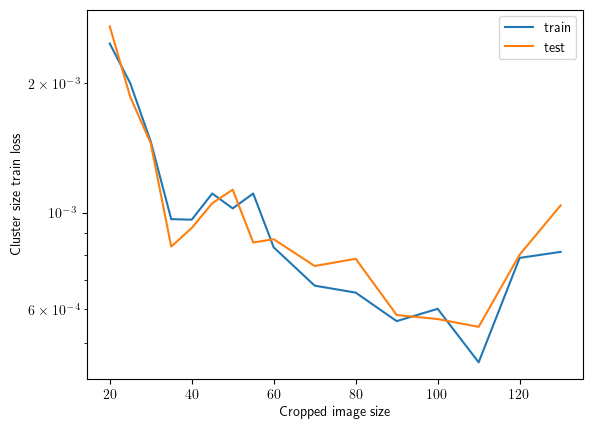

c:\Users\jonat\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


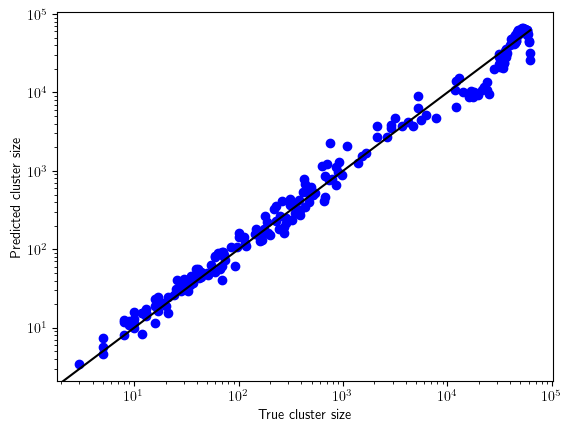

In [104]:
# plot training and test loss for different image sizes
plt.plot(sizes, np.mean(train_loss[:,-5:],axis=1), label='train')
plt.plot(sizes, np.mean(test_loss[:,-5:],axis=1), label='test')
plt.yscale('log')
plt.xlabel("Cropped image size")
plt.ylabel("Cluster size train loss")
plt.legend()
plt.show()

true_value = [] 
pred_value = []
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs, labels = data[0].to(device), data[1].to(device)
        true_value.extend(list(undo_rescale_N(labels.detach().cpu().numpy())))
        pred_value.extend(list(undo_rescale_N(cnn(imgs).detach().cpu().numpy())))
        
# plot predictions of last model trained
plt.scatter(true_value, pred_value,c='b')
plt.plot([0,max(true_value)],[0,max(true_value)],c='k')
plt.xlabel("True cluster size")
plt.ylabel("Predicted cluster size")
plt.xscale('log')
plt.yscale('log')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


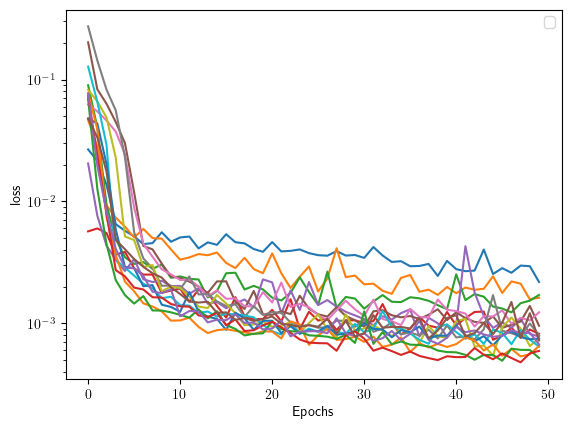

In [107]:
# plot all losses

# plt.plot(np.arange(epochs), train_loss.T)
plt.plot(np.arange(epochs), test_loss.T)
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Training on rgb data

In [108]:

epochs = 50
sizes = [20,25,30,35,40,45,50,55,60,70,80,90,100,110,120,130]
train_loss2 = np.zeros((len(sizes), epochs))
test_loss2 = np.zeros((len(sizes), epochs))

loss_function = torch.nn.MSELoss()

for k, crop_size in enumerate(sizes):
    # the only difference here is that we use 3 input channels as supposed to 1, due to us using rgb
    if k < 5:
        cnn = create_cnn(crop_size, kernel_size=[4,4,3],channel_count=[3,8,16,32], pooling=False)
    else:
        cnn = create_cnn(crop_size, kernel_size=[6,4,3],channel_count=[3,8,16,32])
    optimizer = torch.optim.Adam(cnn.parameters(), lr=4e-4)
    transforms = v2.Compose([
        v2.RandomCrop(crop_size),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
    ])
    dataset = ImageDataset(r"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\data\perco_rgb_img", 
                        transform=transforms, output='N', target_transform=rescale_N)

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        cnn.train()
        epoch_loss = 0
        for i, data in enumerate(train_dataloader):
            imgs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = cnn(imgs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # print(f'epoch: {epoch+1} loss: {epoch_loss / len(train_dataloader):.3e}')
        train_loss2[k, epoch] = epoch_loss/len(train_dataloader)
        
        cnn.eval()
        epoch_loss = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                imgs, labels = data[0].to(device), data[1].to(device)
                outputs = cnn(imgs)
                loss = loss_function(outputs, labels)
                epoch_loss += loss.item()
        test_loss2[k, epoch] = epoch_loss/len(test_dataloader)
        print(f'crop_size: {crop_size}  epoch: {epoch+1}  train loss: {train_loss2[k, epoch]:.3e}  test loss: {test_loss2[k, epoch]:.3e}')
        
    print('Finished Training')


crop_size: 20  epoch: 1  train loss: 1.354e-01  test loss: 6.813e-02
crop_size: 20  epoch: 2  train loss: 3.645e-02  test loss: 2.230e-02
crop_size: 20  epoch: 3  train loss: 9.926e-03  test loss: 9.352e-03
crop_size: 20  epoch: 4  train loss: 5.600e-03  test loss: 5.106e-03
crop_size: 20  epoch: 5  train loss: 4.151e-03  test loss: 4.424e-03
crop_size: 20  epoch: 6  train loss: 3.833e-03  test loss: 3.254e-03
crop_size: 20  epoch: 7  train loss: 3.396e-03  test loss: 3.340e-03
crop_size: 20  epoch: 8  train loss: 3.348e-03  test loss: 3.493e-03
crop_size: 20  epoch: 9  train loss: 3.364e-03  test loss: 3.751e-03
crop_size: 20  epoch: 10  train loss: 3.251e-03  test loss: 4.564e-03
crop_size: 20  epoch: 11  train loss: 3.466e-03  test loss: 2.675e-03
crop_size: 20  epoch: 12  train loss: 3.094e-03  test loss: 3.584e-03
crop_size: 20  epoch: 13  train loss: 2.841e-03  test loss: 3.168e-03
crop_size: 20  epoch: 14  train loss: 2.730e-03  test loss: 2.516e-03
crop_size: 20  epoch: 15  tra

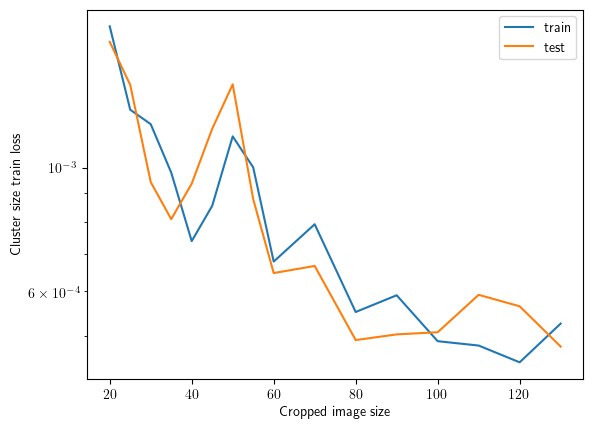

c:\Users\jonat\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


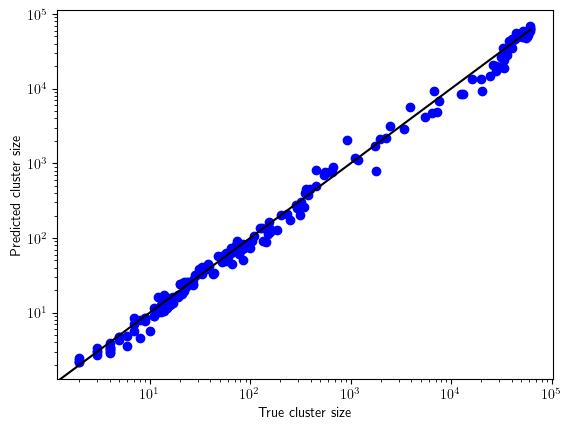

In [110]:
plt.plot(sizes, np.mean(train_loss2[:,-5:],axis=1), label='train')
plt.plot(sizes, np.mean(test_loss2[:,-5:],axis=1), label='test')
plt.yscale('log')
plt.xlabel("Cropped image size")
plt.ylabel("Cluster size train loss")
plt.legend()
plt.show()

true_value = [] 
pred_value = []
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs, labels = data[0].to(device), data[1].to(device)
        true_value.extend(list(undo_rescale_N(labels.detach().cpu().numpy())))
        pred_value.extend(list(undo_rescale_N(cnn(imgs).detach().cpu().numpy())))
        
plt.scatter(true_value, pred_value,c='b')
plt.plot([0,max(true_value)],[0,max(true_value)],c='k')
plt.xlabel("True cluster size")
plt.ylabel("Predicted cluster size")
plt.xscale('log')
plt.yscale('log')
plt.show()



# Percolation probability prediction

In [114]:
# specify seed for the comparison
torch.manual_seed(12)
epochs = 200
# sizes = [20,25,30,35,40,45,50,55,60,70,80,90,100,110,120,130]
train_loss3 = np.zeros(epochs)
test_loss3 = np.zeros(epochs)

# comparing the two loss function: normal MSE and the weighted MSE loss
loss_function = torch.nn.MSELoss()
dense_loss_function = DenseLossFunction(0.05, 0.01)

cnn = create_cnn(250, kernel_size=[6,5,4,4,4],channel_count=[1,8,16,32,32,32], classification=False)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
transforms = v2.Compose([
    # v2.RandomCrop(crop_size),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
])
dataset = ImageDataset(r"C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS495\final\data\perco_prob", 
                    transform=transforms, output='N', )

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
for epoch in range(epochs):  # loop over the dataset multiple times
    cnn.train()
    epoch_loss = 0
    for i, data in enumerate(train_dataloader):
        imgs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = cnn(imgs)
        # using the weighted MSE loss
        loss = dense_loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # print(f'epoch: {epoch+1} loss: {epoch_loss / len(train_dataloader):.3e}')
    train_loss3[epoch] = epoch_loss/len(train_dataloader)
    
    cnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            imgs, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(imgs)
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()
    test_loss3[epoch] = epoch_loss/len(test_dataloader)
    print(f'epoch: {epoch+1}  train loss: {train_loss3[epoch]:.3e}  test loss: {test_loss3[epoch]:.3e}')
    
print('Finished Training')


epoch: 1  train loss: 7.432e-03  test loss: 3.348e-01
epoch: 2  train loss: 5.917e-03  test loss: 2.452e-01
epoch: 3  train loss: 4.730e-03  test loss: 2.144e-01
epoch: 4  train loss: 4.019e-03  test loss: 1.938e-01
epoch: 5  train loss: 3.139e-03  test loss: 1.329e-01
epoch: 6  train loss: 1.946e-03  test loss: 7.297e-02
epoch: 7  train loss: 1.124e-03  test loss: 4.312e-02
epoch: 8  train loss: 4.998e-04  test loss: 2.757e-02
epoch: 9  train loss: 3.794e-04  test loss: 1.540e-02
epoch: 10  train loss: 3.419e-04  test loss: 2.144e-02
epoch: 11  train loss: 3.507e-04  test loss: 1.940e-02
epoch: 12  train loss: 2.949e-04  test loss: 1.835e-02
epoch: 13  train loss: 2.891e-04  test loss: 1.782e-02
epoch: 14  train loss: 3.377e-04  test loss: 1.440e-02
epoch: 15  train loss: 3.419e-04  test loss: 2.260e-02
epoch: 16  train loss: 3.196e-04  test loss: 1.668e-02
epoch: 17  train loss: 2.942e-04  test loss: 2.369e-02
epoch: 18  train loss: 2.532e-04  test loss: 2.550e-02
epoch: 19  train lo

Text(0, 0.5, 'Loss')

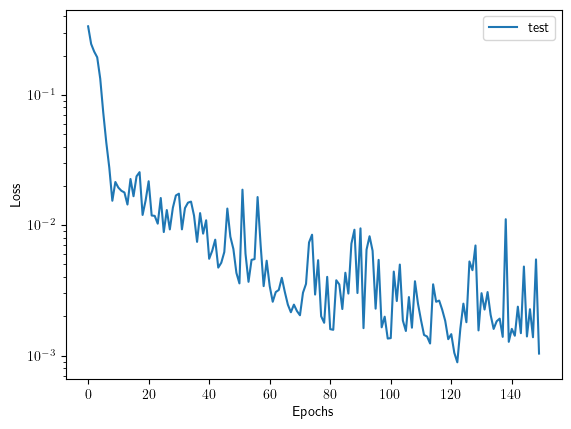

In [116]:
# plotted loss as a function of the epoch number

plt.plot(test_loss3[:150], label='test')
# plt.plot(train_loss3[:150], label='train')
plt.xlabel('Epochs')
plt.legend()
plt.yscale('log')
plt.ylabel('Loss')

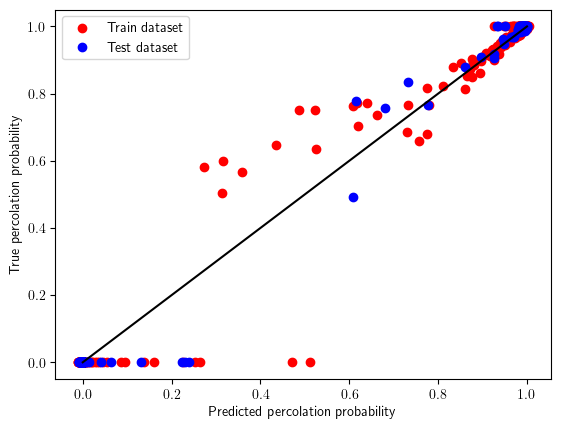

In [115]:
# measuring the predictions of the model compared to their true values

# keep track of predictions and true values on train dataset
y_pred = []
y_true = []
cnn.eval()
epoch_loss = 0
with torch.no_grad():
    for i, data in enumerate(train_dataloader):
        # make predictions and log them
        imgs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(imgs)
        y_true.extend(list(labels.detach().cpu().numpy().flatten()))
        y_pred.extend(list(cnn(imgs).detach().cpu().numpy().flatten()))

# plot train data
plt.scatter(y_pred,y_true, c='r', label='Train dataset')

# do the same thing on the test dataset
y_pred = []
y_true = []
cnn.eval()
epoch_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(imgs)
        y_true.extend(list(labels.detach().cpu().numpy().flatten()))
        y_pred.extend(list(cnn(imgs).detach().cpu().numpy().flatten()))


plt.scatter(y_pred,y_true, c='b', label="Test dataset")
plt.plot([0,max(y_pred)],[0,max(y_pred)],c='k') # ploy x=y line for comparisoin
plt.xlabel("Predicted percolation probability")
plt.ylabel("True percolation probability")
plt.legend()
# plt.yscale('log')
# plt.xscale('log')